## 因子分析part1

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import mstats
from scipy import stats
from datetime import datetime
from pandas import Series
from pandas import DataFrame
from alphalens import utils
from alphalens import plotting
from alphalens import tears
from alphalens import performance
import matplotlib as mpl
import matplotlib.pyplot as plt


### 0、数据准备

In [5]:
# 选择日期
trading_dates = get_trading_dates('2013-05-01','2017-08-01')
trading_dates[0]

datetime.date(2013, 5, 2)

In [27]:
# 获得某段时间内hs300的pe因子数据,将其拼接成有multiindex的dataframe，再转成Series
factor_name = 'pe_ratio'
stocks_sets = index_components('000300.XSHG')
df_facs_datas = DataFrame(index=stocks_sets)
q = query(fundamentals.eod_derivative_indicator.pe_ratio).filter(fundamentals.eod_derivative_indicator.stockcode.in_(stocks_sets))

In [28]:

for i in range(len(trading_dates)):
    daily_fac_data = get_fundamentals(q,trading_dates[i])[0,0,:]  
    df_daily_fac_data = DataFrame(daily_fac_data)
    df_facs_datas[trading_dates[i]] = df_daily_fac_data.loc[stocks_sets]

In [29]:
# 除去异常值和标准化
def winsorize_series(series):   
    q = series.quantile([0.02,0.98])
    if isinstance(q,pd.Series) and len(q) == 2:
        series[series<q.iloc[0]] = q.iloc[0]
        series[series>q.iloc[1]] = q.iloc[1]
    return series
def standardize_series(series):
    std = series.std()
    mean = series.mean()
    #新的数据的平均值为0，
    return (series-mean)/std

    


In [30]:
df_facs_datas=df_facs_datas.apply(winsorize_series,axis=0)
df_facs_datas=df_facs_datas.apply(standardize_series,axis=0)

In [83]:
df_facs_datas.columns=df_facs_datas.columns.astype('datetime64[ns]')

In [86]:
df_facs_unstack=df_facs_datas.unstack()

In [91]:
df_facs_unstack.index.names= ['data','code']
df_facs_unstack.name='pe'

In [92]:
series_facs_datas=df_facs_unstack

In [34]:
price = get_price(stocks_sets, start_date='2017-05-01',end_date = '2017-08-01').close

In [35]:
# 获取收盘价数据：
price.index.name = 'date'
price.columns.name = 'code'
# 看一下价格数据的前几行
price.head()

code,603160.XSHG,601958.XSHG,600060.XSHG,600535.XSHG,002602.XSHE,600919.XSHG,000503.XSHE,002074.XSHE,000895.XSHE,000338.XSHE,...,300033.XSHE,600029.XSHG,001979.XSHE,600690.XSHG,601881.XSHG,000977.XSHE,600827.XSHG,600837.XSHG,300144.XSHE,600373.XSHG
date,,,,,,,,,,,,,,,,,,,,,
2017-05-02,97.4821,7.36,14.9941,41.0016,30.95,8.9398,32.08,31.4715,20.1016,5.3684,...,56.00,7.6864,18.4343,12.7213,12.1797,17.2631,15.3129,14.4054,20.26,21.3361
2017-05-03,97.2729,7.42,14.1978,40.7944,30.50,8.9693,32.72,31.1234,20.1205,5.3251,...,57.25,7.7654,18.5320,12.8784,12.1599,17.3452,16.0143,14.3463,20.10,21.4156
2017-05-04,96.5957,7.29,14.1493,40.8142,30.44,9.0184,32.20,30.7953,20.3661,5.2962,...,57.05,7.7061,18.3562,12.8686,11.9527,17.1446,15.9452,14.3266,20.06,21.0875
2017-05-05,94.7233,7.21,14.0619,41.0016,30.07,8.9202,31.77,29.9302,20.3661,5.1180,...,57.36,7.8148,17.7997,12.9079,11.7257,16.8619,15.9254,14.3759,19.80,20.9483
2017-05-08,96.6057,7.02,14.1007,40.6958,29.30,8.8417,30.78,29.7811,20.2150,4.9929,...,59.47,7.9136,17.3993,12.9963,11.2519,16.2418,15.9946,14.4646,19.80,21.0279


In [36]:
# 获取市值数据,按照上面的方式进行拼接..
df_facs_datas_mc = DataFrame()
q = query(fundamentals.eod_derivative_indicator.market_cap).filter(fundamentals.eod_derivative_indicator.stockcode.in_(stocks_sets))
for i in range(len(trading_dates)):
    daily_fac_mc_data = get_fundamentals(q,trading_dates[i])[0,0,:]

    df_daily_fac_mc_data = DataFrame(daily_fac_mc_data)
    df_daily_fac_mc_data.columns = ['market_value']

    df_daily_fac_mc_data['date'] = trading_dates[i]
    df_facs_datas_mc = pd.concat([df_facs_datas_mc,df_daily_fac_mc_data])



In [37]:
df_facs_datas_mc = df_facs_datas_mc.set_index(['date',df_facs_datas_mc.index])
df_facs_datas_mc.index.names= ['date','code']
series_facs_datas_mc = df_facs_datas_mc['market_value']
series_facs_datas_mc.tail()

date        code       
2017-08-01  601997.XSHG      3.595e+10
            601998.XSHG    3.29821e+11
            603160.XSHG    4.19326e+10
            603858.XSHG    4.59601e+10
            603993.XSHG    1.52275e+11
Name: market_value, dtype: object

In [38]:
port = [1,2,3,4,5]
# 分位数处理，进行分组
def division(series):
    q = series.quantile([0.2,0.4,0.6,0.8])
    if isinstance(q,pd.Series) and len(q) == 4:
        series[series<q.iloc[0]] = port[0]
        series[(series>=q.iloc[0]) & (series<q.iloc[1])] = port[1]
        series[(series>=q.iloc[1]) & (series<q.iloc[2])] = port[2]
        series[(series>=q.iloc[2]) & (series<q.iloc[3])] = port[3]
        series[(series>=q.iloc[3])] = port[4]
    return series



In [39]:
# 将市值因子的数据每天都进行分组
mc_group = series_facs_datas_mc.groupby(level='date').apply(division)
# 标签
mc_label = {1:'very_small_MC',2:'small_MC',3:'mid_MC',4:'big_MC',5:'very_big_MC'}
mc_group.tail()

date        code       
2017-08-01  601997.XSHG    2
            601998.XSHG    5
            603160.XSHG    3
            603858.XSHG    3
            603993.XSHG    5
Name: market_value, dtype: object

#### 下面就进行分析了,一共有
##### Quantiles Statistics，Returns Analysis，Information Analysis，Turnover Analysis

#### 整理数据成规定的格式：

In [21]:
utils.get_clean_factor_and_forward_returns?

<table border="1">
  <tr>
    <th>参数</th>
    <th>类型</th>
    <th>注释</th>
  </tr>
  <tr>
    <td>factor</td>
    <td>pd.Series</td>
    <td>A MultiIndex Series indexed by date (level 0) and asset (level 1), containing
    the values for a single alpha factor.</td>
  </tr>
   <tr>
    <td>prices</td>
    <td>pd.DataFrame</td>
    <td> A wide form Pandas DataFrame indexed by date with assets
    in the columns. It is important to pass the
    correct pricing data in depending on what time of period your
    signal was generated so to avoid lookahead bias, or
    delayed calculations. Pricing data must span the factor
    analysis time period plus an additional buffer window
    that is greater than the maximum number of expected periods
    in the forward returns calculations.</td>
  </tr>
  <tr>
    <td>groupby </td>
    <td>pd.Series</td>
    <td>Either A MultiIndex Series indexed by date and asset,
    containing the period wise group codes for each asset, or
    a dict of asset to group mappings. If a dict is passed,
    it is assumed that group mappings are unchanged for the
    entire time period of the passed factor data.</td>
  </tr>
   <tr>
    <td>by_group  </td>
    <td>bool</td>
    <td>If True, compute statistics separately for each group.</td>
  </tr>
    <tr>
    <td>quantiles  </td>
    <td>int or sequence[float]</td>
    <td>Number of equal-sized quantile buckets to use in factor bucketing.
    Alternately sequence of quantiles, allowing non-equal-sized buckets
    e.g. [0, .10, .5, .90, 1.] or [.05, .5, .95]
    Only one of 'quantiles' or 'bins' can be not-None</td>
  </tr>
    <tr>
    <td>bins </td>
    <td>int or sequence[float]</td>
    <td>Number of equal-width (valuewise) bins to use in factor bucketing.
    Alternately sequence of bin edges allowing for non-uniform bin width
    e.g. [-4, -2, -0.5, 0, 10]
    Only one of 'quantiles' or 'bins' can be not-None</td>
  </tr>
    <tr>
    <td>periods  </td>
    <td>sequence[int]</td>
    <td>periods to compute forward returns on.</td>
  </tr>
    <tr>
    <td>filter_zscore  </td>
    <td>int or float</td>
    <td>Sets forward returns greater than X standard deviations
    from the the mean to nan.
    Caution: this outlier filtering incorporates lookahead bias.</td>
  </tr>
    <tr>
    <td>groupby_labels  </td>
    <td>dict</td>
    <td>A dictionary keyed by group code with values corresponding
    to the display name for each group.</td>
  </tr>
</table>

Return：
 A MultiIndex Series indexed by date (level 0) and asset (level 1),
    containing the values for a single alpha factor, forward returns for each period,
    The factor quantile/bin that factor value belongs too, and (optionally) the group the
    asset belongs to.
    

大致意思就是将上面得到的数据有:'因子数据','价格','市值数据','市值分组的标签'等数据（要符合规格）代入get_clean_factor_and_forward_returns这个函数就可以得到 一个多重索引的dataframe，包含了alpha（在factor那列），每个时期的预期收益(1,5,10)，因子分组的组号（factor_quantile），可能还会有按另一个因子（此处是市值）的分组（group）

In [93]:
facs_data_analysis  = utils.get_clean_factor_and_forward_returns(series_facs_datas,price,groupby=mc_group,groupby_labels=mc_label)
facs_data_analysis.head()

1         5        10    factor          group  \
date       asset                                                                
2017-05-02 603160.XSHG -0.002146 -0.007663  0.010626  0.239552    very_big_MC   
           601958.XSHG  0.008152 -0.036685 -0.063859  3.932544    very_big_MC   
           600060.XSHG -0.053108 -0.065412 -0.079658 -0.700821  very_small_MC   
           600535.XSHG -0.005053 -0.028867 -0.018043 -0.008677  very_small_MC   
           002602.XSHE -0.014540 -0.040388  0.007108  0.755019  very_small_MC   

                        factor_quantile  
date       asset                         
2017-05-02 603160.XSHG                4  
           601958.XSHG                5  
           600060.XSHG                1  
           600535.XSHG                4  
           002602.XSHE                5

In [98]:
# 由于factor那列是object类型，转换成float方便下面继续分析
facs_data_analysis['factor'] = np.float128(facs_data_analysis['factor'])

### 1、 查看一下summary

In [99]:
tears.create_summary_tear_sheet?

<table border="1">
  <tr>
    <th>参数</th>
    <th>类型</th>
    <th>注释</th>
  </tr>
  <tr>
    <td>factor_data</td>
    <td>pd.DataFrame</td>
    <td>pd.DataFrame - MultiIndex
    A MultiIndex DataFrame indexed by date (level 0) and asset (level 1),
    containing the values for a single alpha factor, forward returns for each period,
    The factor quantile/bin that factor value belongs too, and (optionally) the group the
    asset belongs to.</td>
  </tr>
  <tr>
    <td>long_short </td>
    <td>bool</td>
    <td>Should this computation happen on a long short portfolio?</td>
  </tr>
</table>

factor_data:里面放上面通过utils.get_clean_factor_and_forward_returns的dataframe

返回的是一个简易的summary包含（Quantiles Statistics，Returns Analysis，Information Analysis，Turnover Analysis）

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.958126,-0.655536,-0.815477,0.085689,3186,20.274914
2,-0.702939,-0.415063,-0.557722,0.082466,3132,19.931271
3,-0.440682,-0.115072,-0.286901,0.078974,3132,19.931271
4,-0.190551,0.482232,0.097027,0.181120,3132,19.931271
5,0.381321,4.282849,1.577133,1.174968,3132,19.931271


Returns Analysis


,1,5,10
Ann. alpha,-0.277,-0.283,-0.282
beta,0.232,0.279,0.483
Mean Period Wise Return Top Quantile (bps),-11.585,-52.942,-70.136
Mean Period Wise Return Bottom Quantile (bps),17.505,87.503,151.820
Mean Period Wise Spread (bps),-29.090,-28.047,-22.117


Information Analysis


,1,5,10
IC Mean,-0.052,-0.111,-0.152
IC Std.,0.211,0.234,0.203
t-stat(IC),-1.815,-3.482,-5.498
p-value(IC),0.075,0.001,0.000
IC Skew,0.185,0.338,0.517
IC Kurtosis,-0.896,-0.933,-0.575
Ann. IR,-3.921,-7.521,-11.878


Turnover Analysis


,1,5,10
Quantile 1 Mean Turnover,0.016,0.033,0.042
Quantile 2 Mean Turnover,0.038,0.079,0.103
Quantile 3 Mean Turnover,0.042,0.095,0.130
Quantile 4 Mean Turnover,0.033,0.072,0.100
Quantile 5 Mean Turnover,0.013,0.023,0.030


,1,5,10
Mean Factor Rank Autocorrelation,1.0,0.998,0.997


/opt/conda/envs/ricequant/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


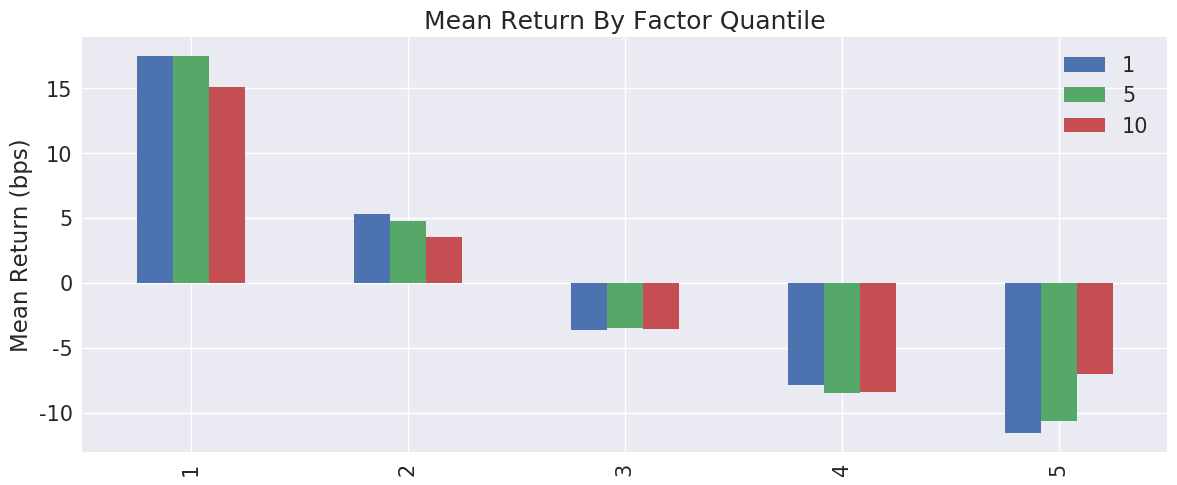

In [100]:
tears.create_summary_tear_sheet(facs_data_analysis)

### 2、 Returns Analysis

In [101]:
tears.create_returns_tear_sheet?

<table border="1">
  <tr>
    <th>参数</th>
    <th>类型</th>
    <th>注释</th>
  </tr>
  <tr>
    <td>factor_data </td>
    <td>pd.DataFrame - MultiIndex</td>
    <td>A MultiIndex DataFrame indexed by date (level 0) and asset (level 1),
    containing the values for a single alpha factor, forward returns for each period,
    The factor quantile/bin that factor value belongs too, and (optionally) the group the
    asset belongs to.</td>
  </tr>
  <tr>
    <td>long_short  </td>
    <td>bool</td>
    <td>Should this computation happen on a long short portfolio?</td>
  </tr>
  <tr>
    <td>by_group  </td>
    <td>bool</td>
    <td>If True, perform calcuations, and display graphs separately for
    each group.</td>
  </tr>
</table>

收益率分析：
分析每个预期收益在每组的情况、以及每个forward Period每组的累积收益；

factor_data:里面放上面通过utils.get_clean_factor_and_forward_returns的dataframe

by_group:如果是True，会每个组都展示图标

可以对于pe看出第一组应该是好于第五组的
在每个Forward Period的高组减去低组的平均收益
每种市值的收益率分析

Returns Analysis


,1,5,10
Ann. alpha,-0.277,-0.283,-0.282
beta,0.232,0.279,0.483
Mean Period Wise Return Top Quantile (bps),-11.585,-52.942,-70.136
Mean Period Wise Return Bottom Quantile (bps),17.505,87.503,151.820
Mean Period Wise Spread (bps),-29.090,-28.047,-22.117


/opt/conda/envs/ricequant/lib/python3.5/site-packages/alphalens/plotting.py:727: FutureWarning: pd.rolling_apply is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=5,min_periods=1).apply(args=<tuple>,func=<function>,kwargs=<dict>)
  min_periods=1, args=(period,))
/opt/conda/envs/ricequant/lib/python3.5/site-packages/alphalens/plotting.py:767: FutureWarning: pd.rolling_apply is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,window=5,min_periods=1).apply(args=<tuple>,func=<function>,kwargs=<dict>)
  min_periods=1, args=(period,))
/opt/conda/envs/ricequant/lib/python3.5/site-packages/alphalens/plotting.py:727: FutureWarning: pd.rolling_apply is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=10,min_periods=1).apply(args=<tuple>,func=<function>,kwargs=<dict>)
  min_periods=1, args=(period,))
/opt/c

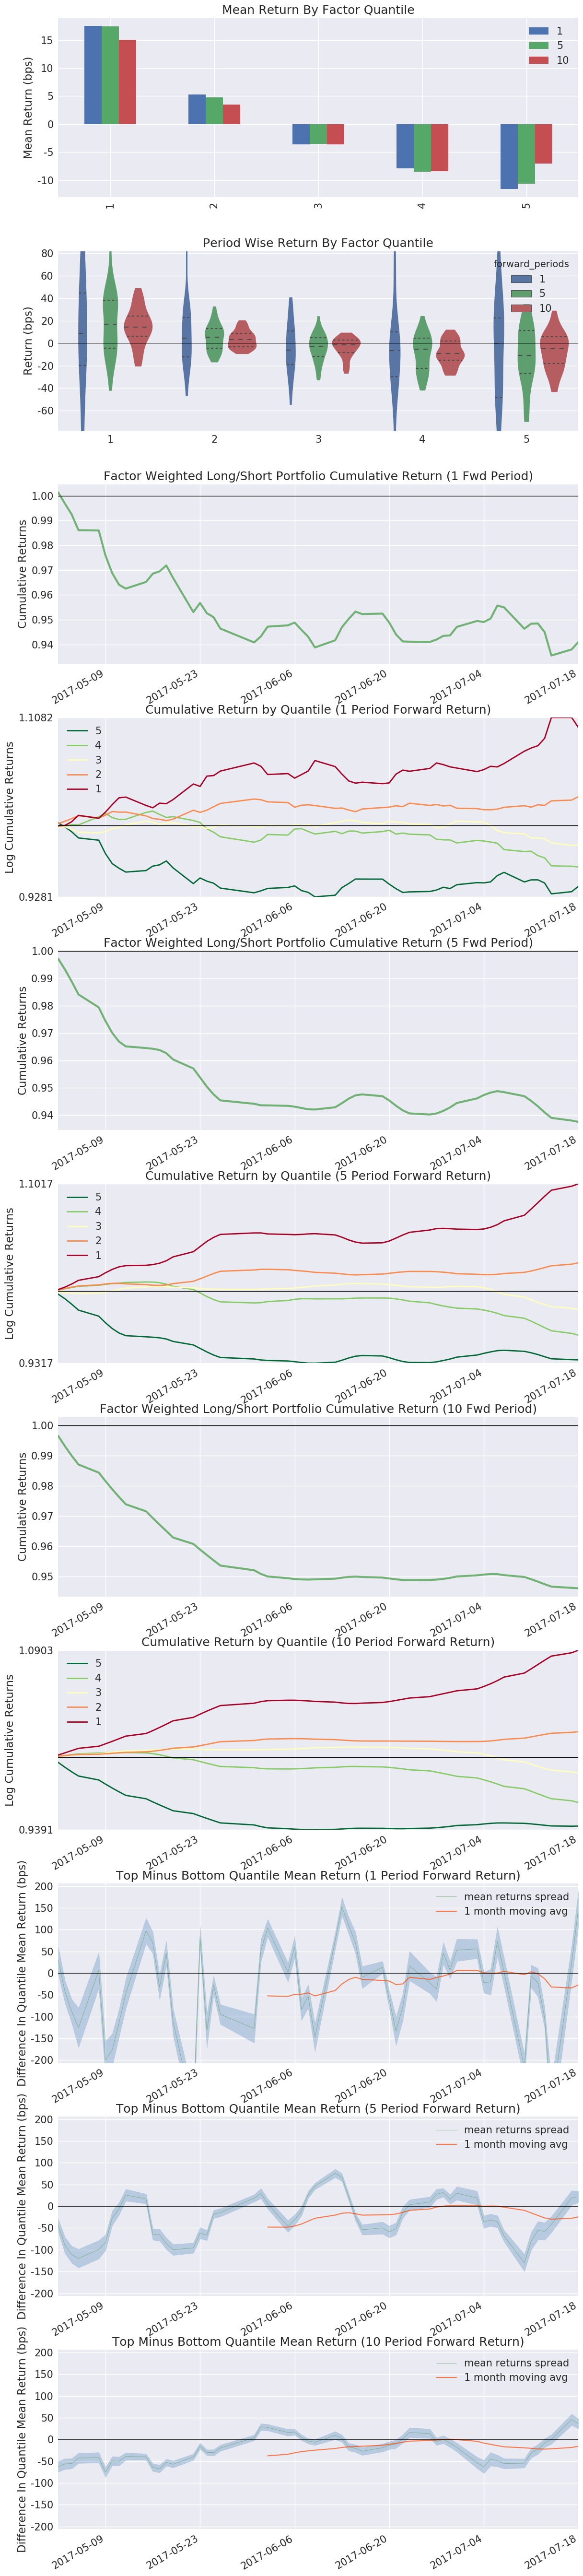

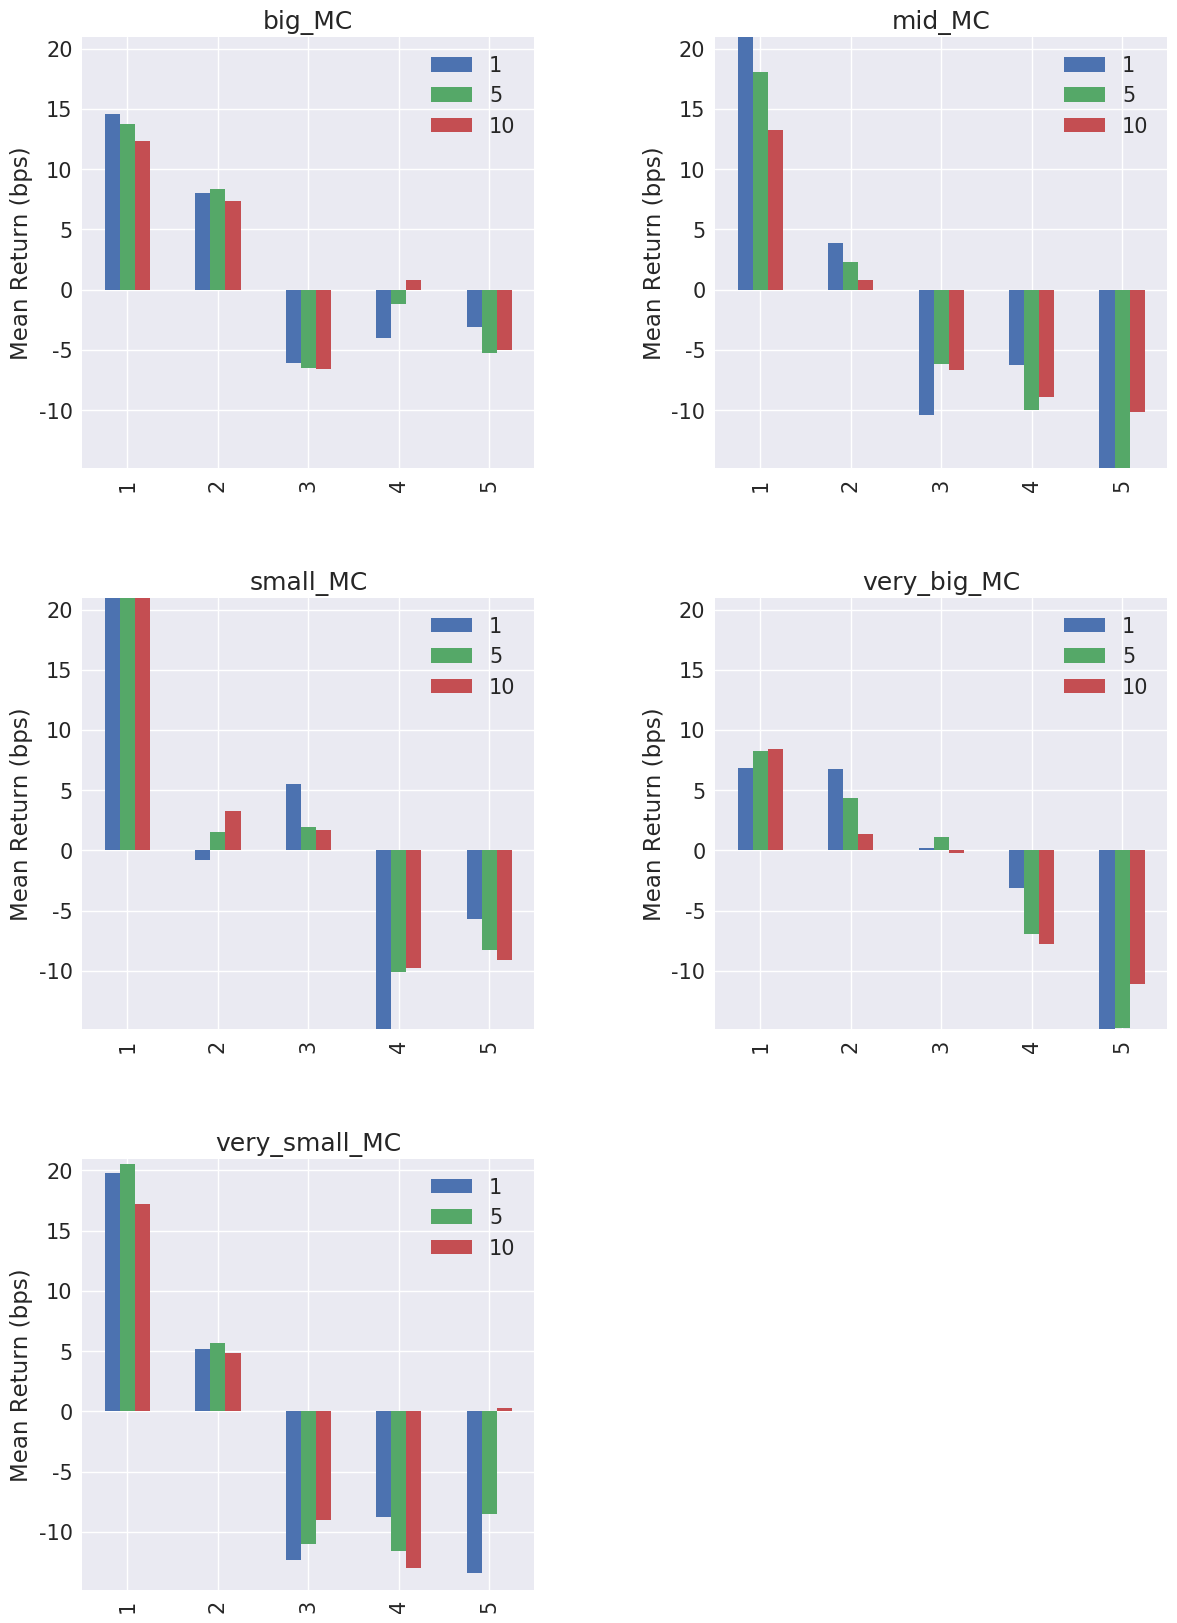

In [102]:
tears.create_returns_tear_sheet(facs_data_analysis,by_group=True)

### 3、 Turnover Analysis

In [103]:
tears.create_turnover_tear_sheet?

<table border="1">
  <tr>
    <th>参数</th>
    <th>类型</th>
    <th>注释</th>
  </tr>
  <tr>
    <td>factor_data </td>
    <td>pd.dataFrame</td>
    <td>A MultiIndex DataFrame indexed by date (level 0) and asset (level 1),
    containing the values for a single alpha factor, forward returns for each period,
    The factor quantile/bin that factor value belongs too, and (optionally) the group the
    asset belongs to.</td>
  </tr>
</table>

Turnover Analysis


,1,5,10
Quantile 1 Mean Turnover,0.016,0.033,0.042
Quantile 2 Mean Turnover,0.038,0.079,0.103
Quantile 3 Mean Turnover,0.042,0.095,0.130
Quantile 4 Mean Turnover,0.033,0.072,0.100
Quantile 5 Mean Turnover,0.013,0.023,0.030


,1,5,10
Mean Factor Rank Autocorrelation,1.0,0.998,0.997


/opt/conda/envs/ricequant/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


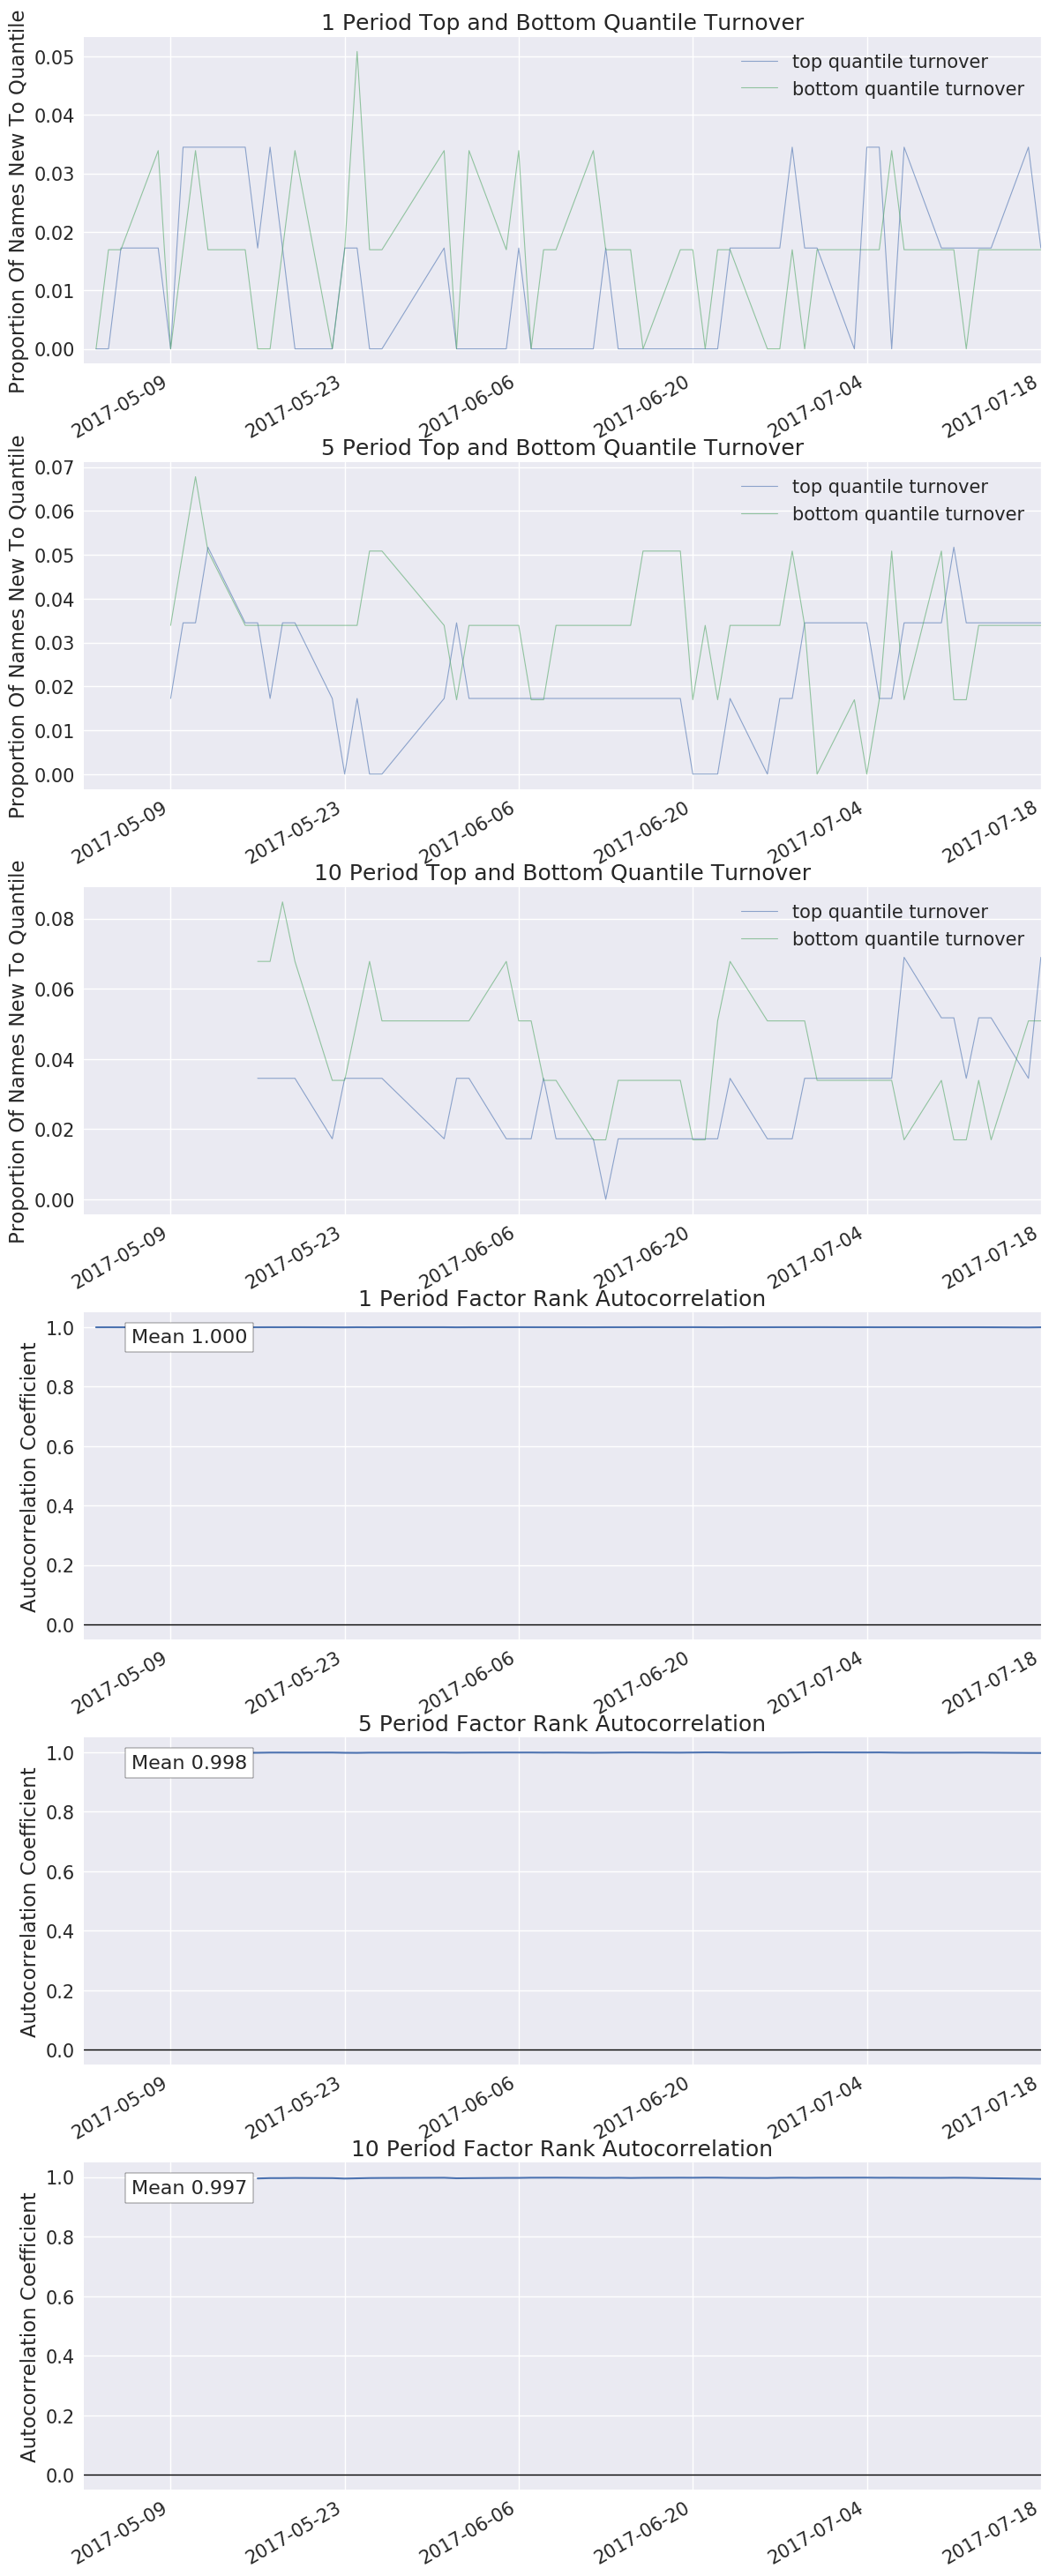

In [104]:
tears.create_turnover_tear_sheet(facs_data_analysis)

### 4、 Information Analysis

In [ ]:
performance.factor_information_coefficient?

<table border="1">
  <tr>
    <th>参数</th>
    <th>类型</th>
    <th>注释</th>
  </tr>
  <tr>
    <td>factor_data</td>
    <td>pd.DataFrame - MultiIndex</td>
    <td>A MultiIndex DataFrame indexed by date (level 0) and asset (level 1),
    containing the values for a single alpha factor, forward returns for each period,
    The factor quantile/bin that factor value belongs too, and (optionally) the group the
    asset belongs to.</td>
  </tr>
  <tr>
    <td>group_adjust </td>
    <td>bool</td>
    <td>Demean forward returns by group before computing IC.</td>
  </tr>
  <tr>
    <td>by_group </td>
    <td>bool</td>
    <td>If True, compute period wise IC separately for each group.</td>
  </tr>
</table>

#### 1、计算因子值和预期收益之间的基于Spearman Rank Correlation（斯皮尔曼等级相关系数）的IC：
Computes the Spearman Rank Correlation based Information Coefficient (IC)
between factor values and N period forward returns for each period in
the factor index;

factor_data:里面放上面通过utils.get_clean_factor_and_forward_returns的dataframe

by_group:如果是True，会每个组都会计算IC;

group_adjust:在计算IC之前是否对预期收益进行处理

返回：Spearman Rank correlation between factor and provided forward returns.

In [105]:
IC = performance.factor_information_coefficient(facs_data_analysis,group_adjust=False,by_group=True)
IC.head()


1         5         10
date       group                                      
2017-05-02 big_MC         0.028712 -0.118665 -0.336038
           mid_MC        -0.134556 -0.352395 -0.375792
           small_MC      -0.048123  0.031187 -0.135328
           very_big_MC    0.289710 -0.021390 -0.070814
           very_small_MC  0.156792 -0.200286 -0.370119

#### 2、Get the mean information coefficient of specified groups.
#### 获得某段时期或某种分组的平均IC

In [ ]:
performance.mean_information_coefficient?

<table border="1">
  <tr>
    <th>参数</th>
    <th>类型</th>
    <th>注释</th>
  </tr>
  <tr>
    <td>factor_data </td>
    <td>pd.DataFrame</td>
    <td>A MultiIndex DataFrame indexed by date (level 0) and asset (level 1),
    containing the values for a single alpha factor, forward returns for each period,
    The factor quantile/bin that factor value belongs too, and (optionally) the group the
    asset belongs to.</td>
  </tr>
  <tr>
    <td>group_adjust  </td>
    <td>bool</td>
    <td>Demean forward returns by group before computing IC.</td>
  </tr>
  <tr>
    <td>by_group  </td>
    <td>bool</td>
    <td>If True, take the mean IC for each group.</td>
  </tr>
  <tr>
    <td>by_time   </td>
    <td>str (pd time_rule), optional</td>
    <td>Time window to use when taking mean IC.
    See http://pandas.pydata.org/pandas-docs/stable/timeseries.html
    for available options.</td>
  </tr>
</table>

factor_data:里面放上面通过utils.get_clean_factor_and_forward_returns的dataframe

by_group:如果是True，计算每组的平均IC

group_adjust:在计算IC之前是否对预期收益进行处理

by_time:(按哪种时间规则计算，1q=1季度，1w=1周)

In [106]:
performance.mean_information_coefficient(facs_data_analysis,
                                 group_adjust=False,
                                 by_group=True,
                                 by_time='1q')

1         5         10
date       group                                      
2017-06-30 big_MC        -0.062112 -0.105800 -0.178167
           mid_MC        -0.037706 -0.089281 -0.132582
           small_MC      -0.053643 -0.124816 -0.201538
           very_big_MC   -0.018139 -0.022198 -0.022686
           very_small_MC -0.034980 -0.080819 -0.155645
2017-09-30 big_MC        -0.006532 -0.101129 -0.083029
           mid_MC        -0.086333 -0.162805 -0.093292
           small_MC      -0.088140 -0.217921 -0.302030
           very_big_MC   -0.109369 -0.311063 -0.333945
           very_small_MC -0.116334 -0.242128 -0.176037

### 5、 其他

In [ ]:
performance.factor_alpha_beta?

<table border="1">
  <tr>
    <th>参数</th>
    <th>类型</th>
    <th>注释</th>
  </tr>
  <tr>
    <td>factor_data </td>
    <td>pd.DataFrame</td>
    <td>A MultiIndex DataFrame indexed by date (level 0) and asset (level 1),
    containing the values for a single alpha factor, forward returns for each period,
    The factor quantile/bin that factor value belongs too, and (optionally) the group the
    asset belongs to.</td>
  </tr>

</table>

#### 计算alpha和beta
根据因子和预期收益计算alpha，beta等；
factor_data:里面放上面通过utils.get_clean_factor_and_forward_returns的dataframe；

    Compute the alpha (excess returns), alpha t-stat (alpha significance),
    and beta (market exposure) of a factor. A regression is run with
    the period wise factor universe mean return as the independent variable
    and mean period wise return from a portfolio weighted by factor values
    as the dependent variable.

In [107]:
performance.factor_alpha_beta(facs_data_analysis)

,1,5,10
Ann. alpha,-0.276715,-0.283321,-0.281792
beta,0.231923,0.279179,0.483088


In [ ]:
tears.create_event_returns_tear_sheet?

<table border="1">
  <tr>
    <th>参数</th>
    <th>类型</th>
    <th>注释</th>
  </tr>
  <tr>
    <td>factor_data </td>
    <td>pd.DataFrame - MultiIndex</td>
    <td>A MultiIndex Series indexed by date (level 0) and asset (level 1),
    containing the values for a single alpha factor, forward returns for each period,
    The factor quantile/bin that factor value belongs too, and (optionally) the group the
    asset belongs to.</td>
  </tr>
  <tr>
    <td>prices  </td>
    <td>pd.DataFrame</td>
    <td>A wide form Pandas DataFrame indexed by date with assets
    in the columns. Pricing data should span the factor
    analysis time period plus/minus an additional buffer window
    corresponding to periods_after/periods_before parameters.</td>
  </tr>
  <tr>
    <td>avgretplot </td>
    <td>tuple (int, int) - (before, after)</td>
    <td>If not None, plot quantile average cumulative returns</td>
  </tr>
  <tr>
    <td>long_short  </td>
    <td>bool</td>
    <td>Should this computation happen on a long short portfolio?</td>
  </tr>
  <tr>
    <td>by_group  </td>
    <td>bool</td>
    <td>If True, view the average cumulative returns for each group.</td>
  </tr>

</table>

这个函数是观察每组的累积收益的，可以在avgretplot调整要观察的period;

在by_group如果是True将会每组都展示平均累积收益

Creates a tear sheet to view the average cumulative returns for a 
factor within a window (pre and post event).

/opt/conda/envs/ricequant/lib/python3.5/site-packages/matplotlib/axes/_axes.py:2876: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)
/opt/conda/envs/ricequant/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


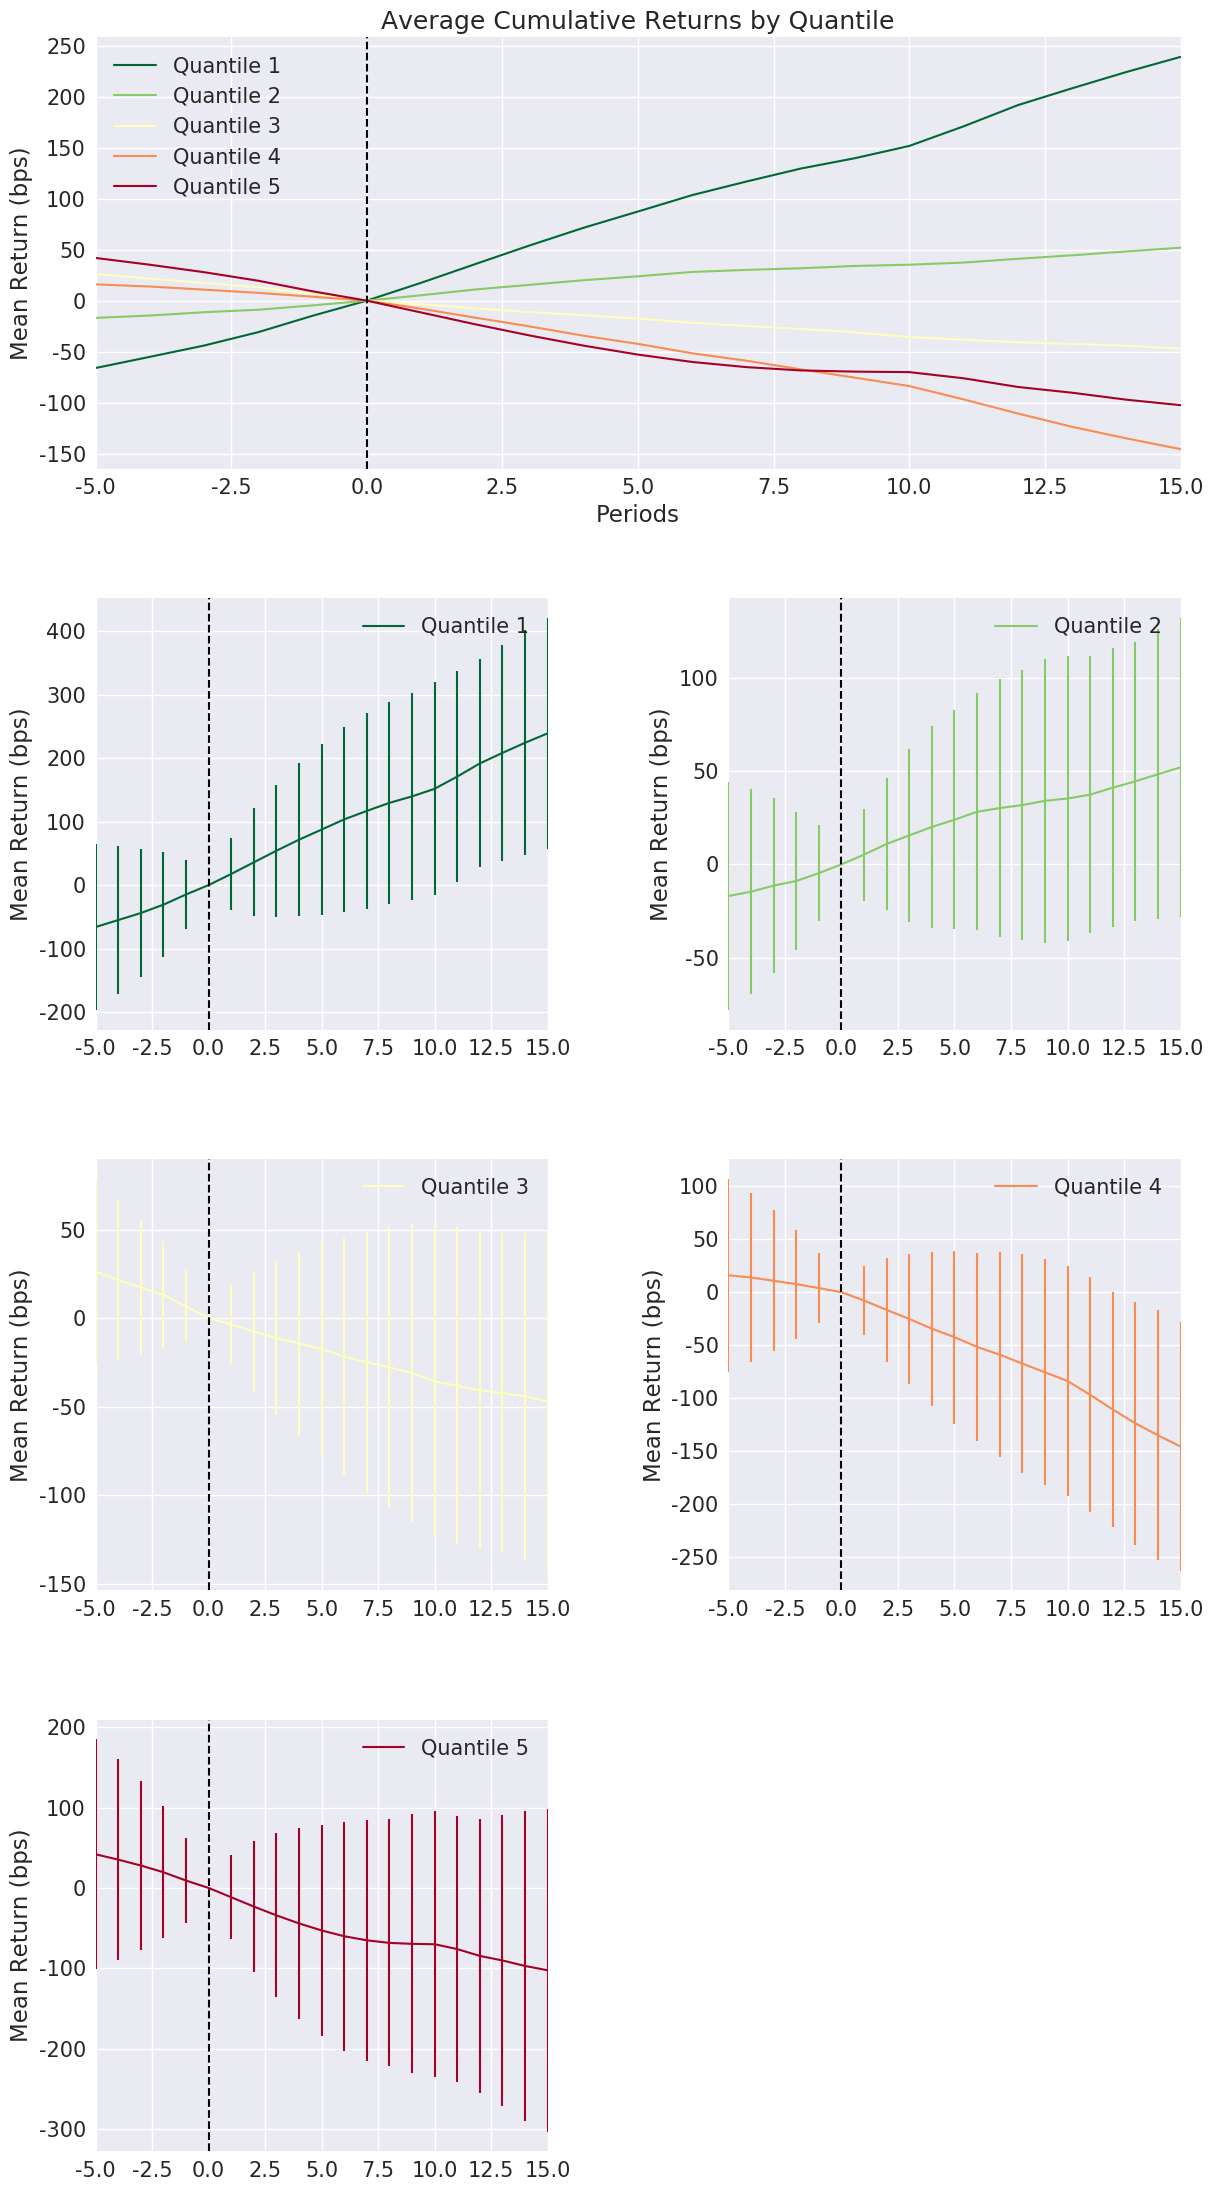

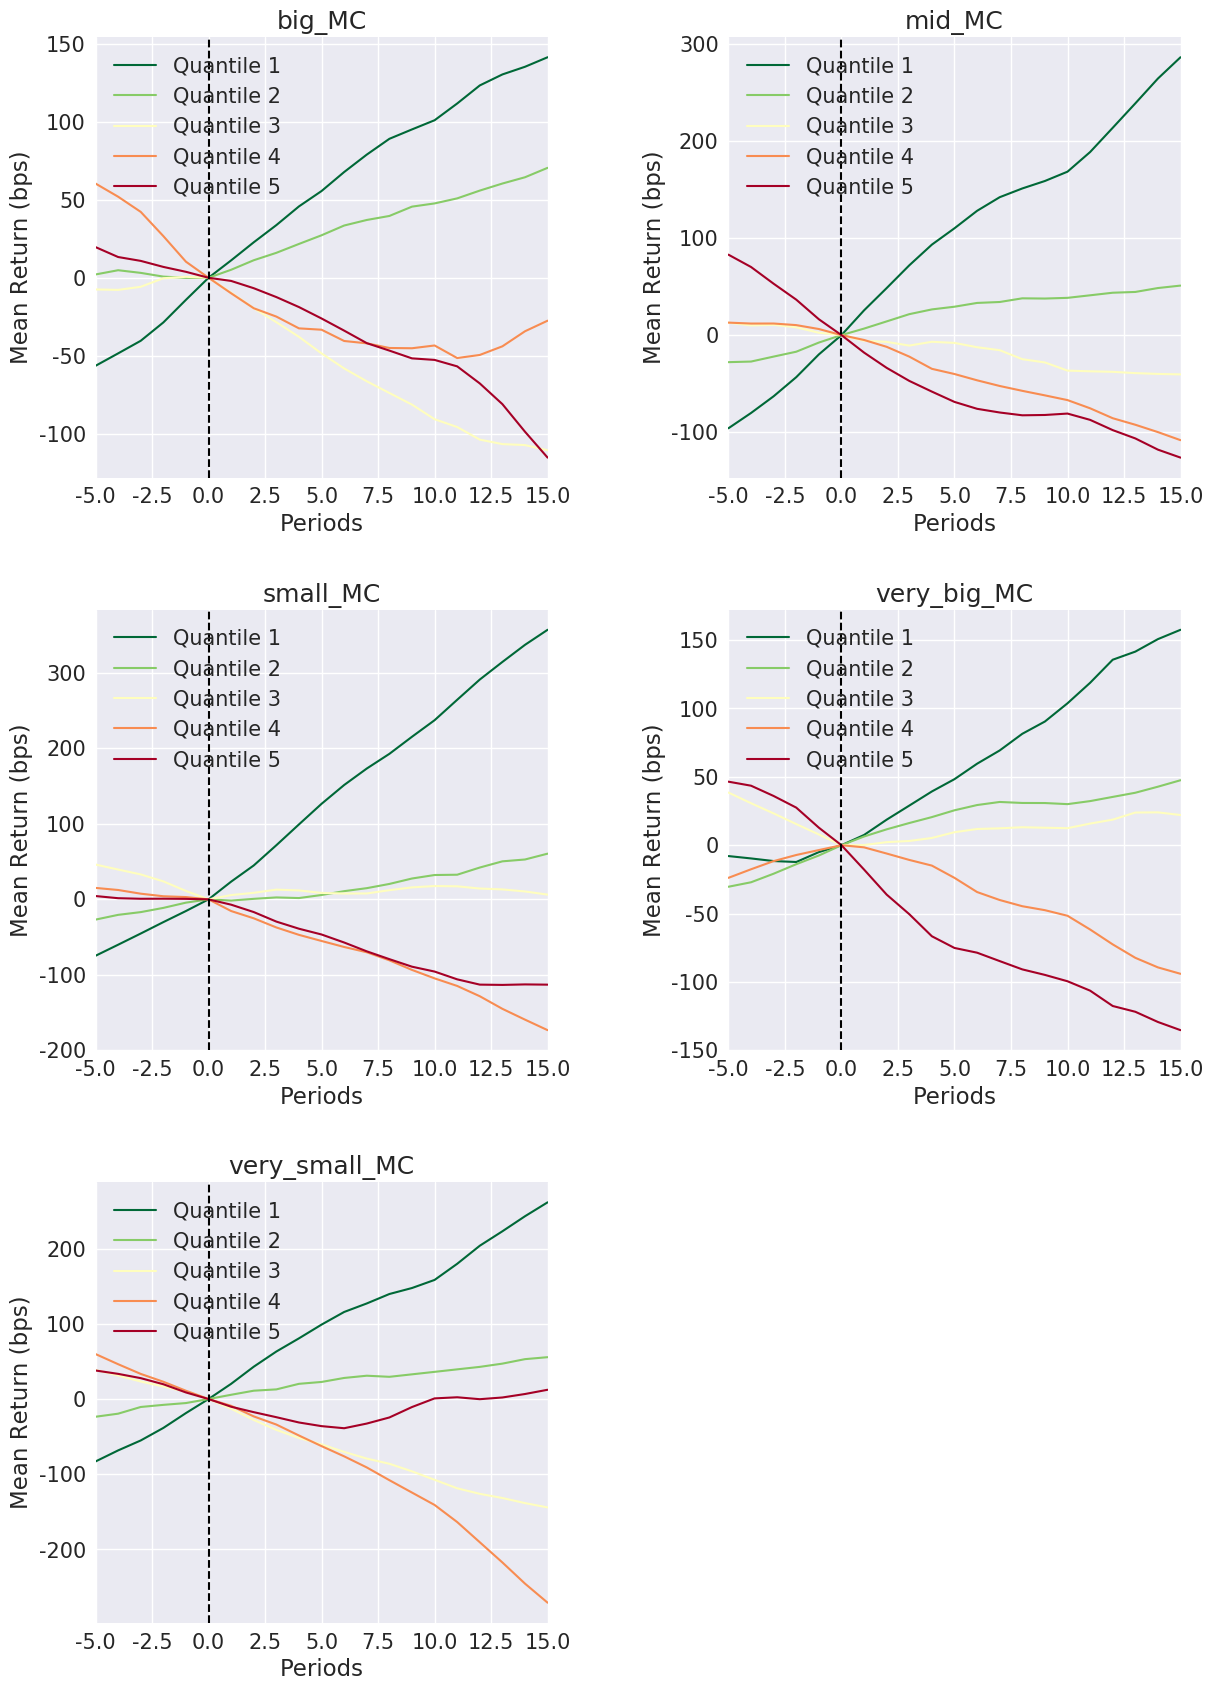

In [108]:
tears.create_event_returns_tear_sheet(facs_data_analysis,prices=price,avgretplot=(5, 15),
                                    long_short=True,
                                    by_group=True)